In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
%matplotlib inline

- Currently, there are **many deep learning frameworks** that are used to deal with the complexity of gradient calculations

- We know that before it was very difficult to train neural networks, but today we have many techniques that we can use to have a more **efficient training**

- Even though we have several techniques and several frameworks available to train neural networks, it is always important to have a **sense of what happens behind the frameworks**, this ensures that we have full control of what we are actually doing .

In [ ]:
with open('/content/names.txt',mode='r',encoding='utf-8') as f:
  words=f.read().split()

In [ ]:
vocab=sorted(set(list(''.join(words))))

In [ ]:
# build the vocabulary of characters and mapping to /from integers
stoi ={s:i+1 for i , s in enumerate(vocab)}
stoi['.']=0
# reverse mapping
itos={i:s for  s,i in stoi.items()}

In [ ]:
def build_dataset(words):

  X,Y=[],[]

  block_size=3
  context=[0]*block_size
  for w in words:
    for ch in w + '.':
      ix=stoi[ch]
      X.append(context)
      Y.append(ix)
      context=context[1:] + [ix]

  X=torch.tensor(X)
  Y=torch.tensor(Y)
  print(X.shape,Y.shape)

  return X,Y

In [ ]:
block_size=3

In [ ]:
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr,Ytr=build_dataset(words[:n1]) #  80%
Xdev,Ydev=build_dataset(words[n1:n2]) #  10%
Xte,yte=build_dataset(words[n2:]) # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
n_embed=10
n_hidden=200


g=torch.Generator().manual_seed(2134563788) # for reproducibility
C=torch.randn([len(vocab)+1,n_embed],             generator=g)
W1=torch.randn([n_embed * block_size,n_hidden] ,  generator=g) *(5/3) / ((n_embed * block_size)**0.5)  #0.2
b1=torch.randn(n_hidden,                          generator=g) *0.01
W2=torch.randn([n_hidden,len(vocab)+1],           generator=g)*0.01
b2=torch.randn(len(vocab)+1,                      generator=g)*0

bngain=torch.ones(1,n_hidden                             )
bnbias=torch.zeros(1,n_hidden                            )
bnmean_running=torch.zeros(1,n_hidden                    )
bnstd_running=torch.zeros(1,n_hidden                     )
parameters=[C,W1,b1,W2,b2,bngain,bnbias]


In [ ]:
sum(p.nelement() for   p in parameters) # total numbers of parameters

12297

In [ ]:
for p  in parameters :
  p.requires_grad=True

In [ ]:
lossi=[]

In [ ]:
batch_size=32
max_steps=10000

for  i in range(max_steps):

  # minibatch construct
  ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
  Xb,Yb=Xtr[ix],Ytr[ix] # batch X,Y

  # forward pass
  emb=C[Xb] # embed the characters into vectors
  embcat=emb.view(emb.shape[0],emb.shape[1]*emb.shape[2]) # concatenate the vectors
  hpreact=embcat @ W1+b1 #  hidden layer pre - activation
  # BatchNorm layer
  # ------------------------------------------------------
  bnmeani=hpreact.mean(axis=0,keepdim=True)
  bnstdi=hpreact.std(axis=0,keepdim=True)
  hpreact=bngain*(hpreact-bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running=0.999 * bnmean_running + 0.001*bnmeani
    bnstd_running=0.999 * bnstd_running + 0.001*bnstdi


  h=torch.tanh(hpreact) # hidden layer
  logits=h @ W2+b2 # output layer
  loss=F.cross_entropy(logits,Ytr[Yb]) # loss_funtion
  #print(f'loss:{loss.item()},epochs:{i+1}')

  for  p in parameters:
    p.grad=None

  # backward pass
  loss.backward()

  # update
  lr=0 if i  < 10000 else 0.01
  for p  in parameters:
    p.data+=-lr*p.grad

  # strack stats
  if i % 1000==0:# print every once in while
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/  10000:3.3009
   1000/  10000:3.2686
   2000/  10000:3.2939
   3000/  10000:3.2873
   4000/  10000:3.3110
   5000/  10000:3.3164
   6000/  10000:3.3180
   7000/  10000:3.3078
   8000/  10000:3.3183
   9000/  10000:3.2980


In [ ]:
@torch.no_grad()
def  split_loss(split):
  x,y={
      'train':(Xtr,Ytr),
      'val':(Xdev,Ydev),
      'test':(Xte,yte),
  }[split]

  emb=C[x]
  embcat=emb.view(emb.shape[0],emb.shape[1]*emb.shape[2])
  hpreact=embcat @ W1 + b1
  hpreact=bngain*(hpreact-bnmean_running) / bnstd_running + bnbias
  h=torch.tanh(hpreact)
  logits=h @ W2+ b2
  loss=F.cross_entropy(logits,y)
  print(split,loss.item())

split_loss('train')
split_loss('val')

train 3.299492120742798
val 3.2995262145996094


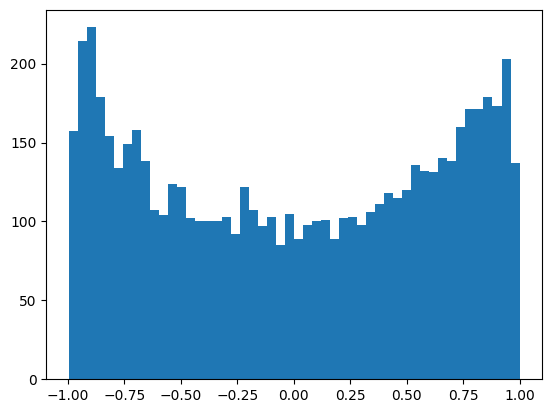

In [ ]:
plt.hist(h.view(-1).tolist(),50);

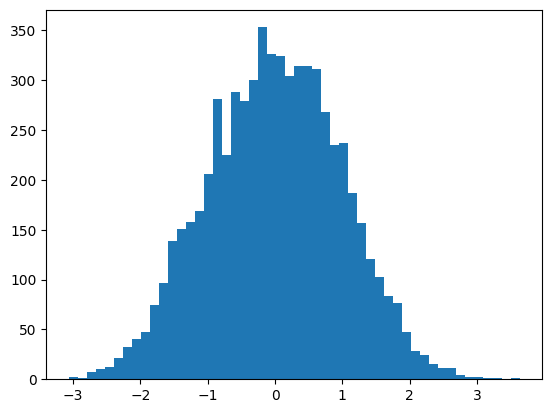

In [ ]:
plt.hist(hpreact.view(-1).tolist(),50);

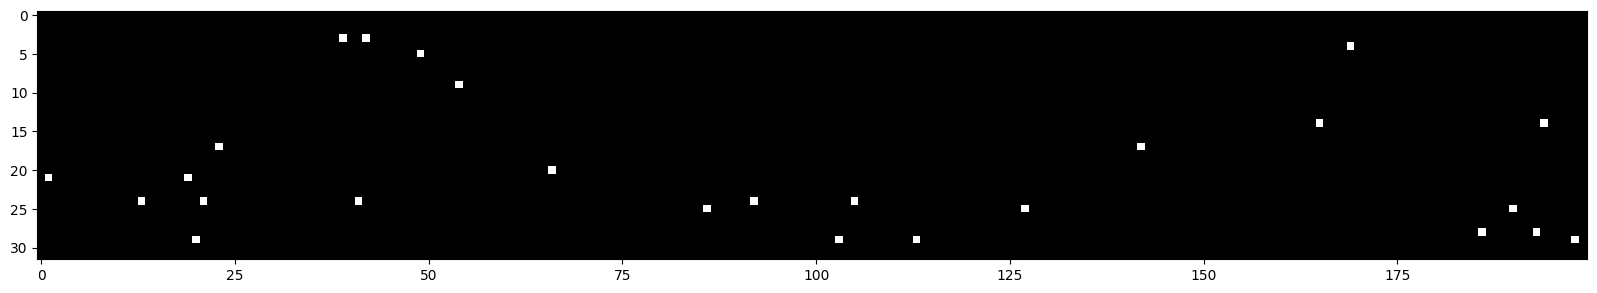

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99,cmap='gray',interpolation='nearest')

In [ ]:
# utility function we will user later when comparing manual gradients to pytorch gradients
def cmp(s,dt,t):
  ex=torch.all(dt == t.grad).item()
  app=torch.allclose(dt,t.grad)
  maxdiff=(dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact : {str(ex):5s} | approximate :{str(app):5s} | maxdiff : {maxdiff}')

In [ ]:
n_embed=10
n_hidden=200


g=torch.Generator().manual_seed(2134563788) # for reproducibility
C=torch.randn([len(vocab)+1,n_embed],             generator=g)
W1=torch.randn([n_embed * block_size,n_hidden] ,  generator=g) *(5/3) / ((n_embed * block_size)**0.5)  #0.2
b1=torch.randn(n_hidden,                          generator=g) *0.01
W2=torch.randn([n_hidden,len(vocab)+1],           generator=g)*0.01
b2=torch.randn(len(vocab)+1,                      generator=g)*0

bngain=torch.ones(1,n_hidden                             )
bnbias=torch.zeros(1,n_hidden                            )
bnmean_running=torch.zeros(1,n_hidden                    )
bnstd_running=torch.zeros(1,n_hidden                     )
parameters=[C,W1,b1,W2,b2,bngain,bnbias]
for  p  in  parameters:
  p.requires_grad = True

In [ ]:
# minibatch construct
batch_size = 32
n = batch_size
ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
Xb,Yb = Xtr[ix],Ytr[ix] # batch X,Y

In [ ]:
# forward pass , "chunked" into smaller steps that are  possible to  backward one at time
emb=C[Xb] #embed the characters into vectors
embcat=emb.view(emb.shape[0],-1) # concatenate the vectores
# Layer 1
hprebn=embcat @ W1+ b1
# Batchnorm layer
bnmeani = 1/n*hprebn.sum(axis=0,keepdim=True)
bndiff = hprebn-bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(axis=0,keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain*bnraw + bnbias
# Non - linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2+b2 # output layer
# cross_entropy loss (same as F.cross_entropy(logits,Yb))
logits_maxes = logits.max(1,keepdim=True).values
norm_logits = logits - logits_maxes # subtract max for numerical
counts = norm_logits.exp()
counts_sum = counts.sum(1,keepdims=True)
counts_sum_inv = counts_sum**-1
probs=counts * counts_sum_inv
logprobs=probs.log()
loss=-logprobs[range(n),Yb].mean()

# Pytorch backward pass

for p in parameters:
  p.grad = None
for t in [logprobs,probs,counts,counts_sum,counts_sum_inv,
          norm_logits,logits_maxes,logits,h,hpreact,bnraw,
          bnvar,bnvar_inv, bndiff2,bndiff,hprebn,bnmeani,
          embcat,emb]:
          t.retain_grad()
loss.backward()
loss

tensor(3.2681, grad_fn=<NegBackward0>)

In [ ]:
bndiff2.shape,bnvar.shape

(torch.Size([32, 200]), torch.Size([1, 200]))

#**1-Backproping the atomic compute graph**

In [ ]:
 # Exercice 1:backprop  through the whole thing manually,
 # backpropagation through exatcly all of the variables
 # as they are defined in the forward pass above , one by one

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n),Yb] = -1.0/n
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1,keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum  = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorms_logits = counts * dcounts
dlogits=dnorms_logits.clone()
dlogits_maxes=(-dnorms_logits).sum(1,keepdims=True)
dlogits += F.one_hot(logits.max(1).indices,num_classes = logits.shape[1] ) * dlogits_maxes
dh = dlogits @ W2.T
dw2 = h.T @ dlogits
db2 = dlogits.sum(axis=0)
dhpreact = (1.0 -h**2 ) * dh
dbgain = (bnraw * dhpreact).sum(0,keepdims=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0,keepdims=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0,keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0 / (n-1)) * torch.ones_like(bndiff2) * dbnvar
dbndiff += (2 * bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbmeani = (-dbndiff).sum(0)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbmeani)
dembcat = dhprebn @ W1.T
dw1 = embcat.T @ dhprebn
db1 = dhprebn.sum(axis=0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k,j]
    dC[ix] +=demb[k,j]

# **2-Cross entropy loss backward pass**

In [ ]:
# backward pass

dlogits = F.softmax(logits,1)
dlogits[range(n),Yb]-=1
dlogits /=n

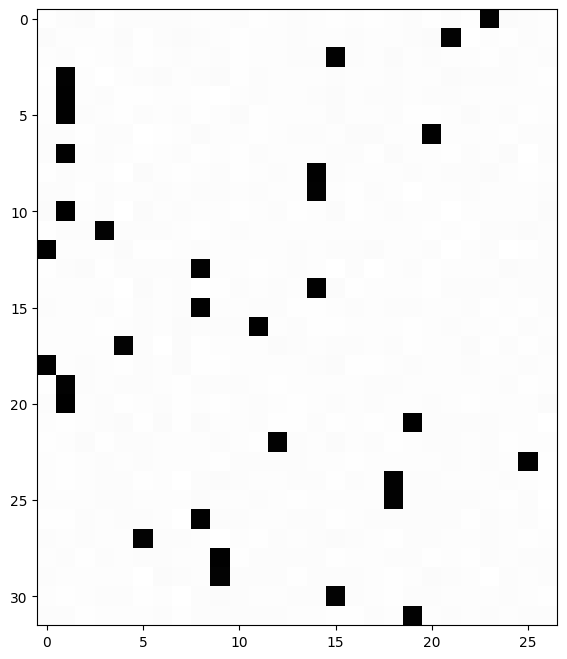

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(),cmap = "gray")

# **3-Batch norm layer backward pass**

In [ ]:
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0)-n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
dhprebn

tensor([[ 1.3234e-05,  2.4389e-05,  2.9211e-05,  ...,  4.6362e-05,
          2.7245e-06,  7.4904e-05],
        [ 6.0518e-05, -1.0817e-05, -1.3282e-05,  ..., -2.6467e-05,
          2.9234e-05, -1.3330e-04],
        [ 4.9586e-05, -9.4295e-05, -9.4862e-06,  ...,  9.3103e-05,
          8.4356e-05, -5.0623e-05],
        ...,
        [-1.9664e-04,  1.2976e-05, -4.2005e-05,  ..., -4.3275e-05,
         -8.4808e-05,  1.8783e-05],
        [ 4.7198e-05, -2.7865e-04, -4.2570e-05,  ...,  9.9280e-05,
          1.8484e-04,  7.9528e-05],
        [-1.8205e-05, -4.3512e-06,  1.3175e-04,  ...,  1.7871e-05,
         -1.1793e-05,  7.5419e-05]], grad_fn=<MulBackward0>)

#**4-Putting it all together**

In [ ]:
n_embed=10
n_hidden=200


g=torch.Generator().manual_seed(2134563788) # for reproducibility
C=torch.randn([len(vocab)+1,n_embed],             generator=g)
W1=torch.randn([n_embed * block_size,n_hidden] ,  generator=g) *(5/3) / ((n_embed * block_size)**0.5)  #0.2
b1=torch.randn(n_hidden,                          generator=g) *0.01
W2=torch.randn([n_hidden,len(vocab)+1],           generator=g)*0.01
b2=torch.randn(len(vocab)+1,                      generator=g)*0

bngain=torch.ones(1,n_hidden                             )
bnbias=torch.zeros(1,n_hidden                            )
bnmean_running=torch.zeros(1,n_hidden                    )
bnstd_running=torch.zeros(1,n_hidden                     )
parameters=[C,W1,b1,W2,b2,bngain,bnbias]

for  p  in  parameters:
  p.requires_grad = True

# minibatch construct
batch_size = 32
n = batch_size
ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
Xb,Yb = Xtr[ix],Ytr[ix] # batch X,Y



batch_size=32
max_steps=30000

for  i in range(max_steps):

  # minibatch construct
  ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
  Xb,Yb=Xtr[ix],Ytr[ix] # batch X,Y

  # forward pass
  emb=C[Xb] # embed the characters into vectors
  embcat=emb.view(emb.shape[0],emb.shape[1]*emb.shape[2]) # concatenate the vectors
  hpreact=embcat @ W1+b1 #  hidden layer pre - activation
  # BatchNorm layer
  # ------------------------------------------------------
  bnmeani=hpreact.mean(axis=0,keepdim=True)
  bnstdi=hpreact.std(axis=0,keepdim=True)
  hpreact=bngain*(hpreact-bnmeani) / bnstdi + bnbias
  h=torch.tanh(hpreact) # hidden layer
  logits=h @ W2+b2 # output layer
  loss=F.cross_entropy(logits,Ytr[Yb]) # loss_funtion
  #print(f'loss:{loss.item()},epochs:{i+1}')

  for  p in parameters:
    p.grad=None

  # backward pass
  loss.backward() # use this for correctness comparisons , delete it later

  # manual backprop !

  # =====================
  dC,dW1,db1,dW2,db2,dbgain,dbnbias = None, None, None, None, None, None, None
  grads=[dC,dW1,db1,dW2,db2,dbgain,dbnbias]
  #-------------------------

  # update
  lr=0 if i  < 10000 else 0.01
  for p,grad in zip(parameters,grads):
    p.data+=-lr*p.grad

  # strack stats
  if i % 1000 == 0:# print every once in while
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/  30000:3.2901
   1000/  30000:3.3001
   2000/  30000:3.2737
   3000/  30000:3.2920
   4000/  30000:3.3171
   5000/  30000:3.3267
   6000/  30000:3.2867
   7000/  30000:3.2830
   8000/  30000:3.2960
   9000/  30000:3.3024
  10000/  30000:3.2971
  11000/  30000:2.7539
  12000/  30000:2.2512
  13000/  30000:2.2827
  14000/  30000:2.1635
  15000/  30000:2.1103
  16000/  30000:2.0355
  17000/  30000:2.0626
  18000/  30000:2.1539
  19000/  30000:2.3251
  20000/  30000:2.1976
  21000/  30000:1.8791
  22000/  30000:2.0602
  23000/  30000:1.9115
  24000/  30000:1.8518
  25000/  30000:1.8880
  26000/  30000:2.0821
  27000/  30000:2.0353
  28000/  30000:2.0162
  29000/  30000:1.8841


In [ ]:
 # calibrate the batch norm at the end of training


with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 + b1
  bnmean = hpreact.mean(0,keepdim = True)
  bnvar = hpreact.var(0,keepdim = True,unbiased = True)

In [ ]:
# evaluate train and val loss

@torch.no_grad()
def split_loss(split):
  x,y = {
      "train":(Xtr,Ytr),
       "val":(Xdev,Ydev),
       "test":(Xte,yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar  + 1e-5)**0.5 + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,y)
  print(split,loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 3.301647424697876
val 3.3016700744628906
test 3.30075740814209
